## Photons list

In [1]:
from pathlib import Path
from astropy.io import fits
import pandas as pd
import numpy as np

In [2]:
from RTAscience.cfg.Config import Config

In [3]:
datapath = Path("/data01/home/baroncelli/phd/DATA")
simFolder = datapath.joinpath("obs/obs_st_grb_tr_1_os_1800_emin_0.03_emax_0.15_roi_2.5")
cfg = Config(simFolder.joinpath("config.yaml"))
runid = cfg.get('runid')

In [4]:
if cfg.get("simtype") == 'bkg':
    inputFitsFile = simFolder.joinpath("backgrounds","bkg000001.fits")
else:
    inputFitsFile = simFolder.joinpath(runid,"ebl000001.fits")    

In [5]:
hdul = fits.open(inputFitsFile)
hdul.info()

Filename: /data01/home/baroncelli/phd/DATA/obs/obs_st_grb_tr_1_os_1800_emin_0.03_emax_0.15_roi_2.5/run0406_ID000126/ebl000001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EVENTS        1 BinTableHDU     78   420610R x 8C   [J, D, E, E, E, E, E, J]   
  2  GTI           1 BinTableHDU     18   1R x 2C   [1D, 1D]   


In [6]:
hdul[1].columns.names

['EVENT_ID', 'TIME', 'RA', 'DEC', 'ENERGY', 'DETX', 'DETY', 'MC_ID']

In [7]:
hdul[1].data

FITS_rec([(     1, 1.63668394e-03, 30.086067, -51.93107 , 0.03273834, -0.12742558, -1.8313961 , 1),
          (     2, 3.73130441e-02, 34.29773 , -51.75047 , 0.08917169,  0.08399371,  0.76808393, 1),
          (     3, 4.39919233e-02, 34.149433, -53.5197  , 0.04224574, -1.683607  ,  0.6495694 , 1),
          ...,
          (420608, 4.31183973e+03, 32.780113, -52.625797, 0.03150018, -0.78511804, -0.16807964, 2),
          (420609, 4.31184896e+03, 33.884956, -50.571167, 0.03887009,  1.2668632 ,  0.5258819 , 2),
          (420610, 4.31187380e+03, 34.925415, -50.823273, 0.04525762,  1.0026634 ,  1.1802391 , 2)],
         dtype=(numpy.record, [('EVENT_ID', '>i4'), ('TIME', '>f8'), ('RA', '>f4'), ('DEC', '>f4'), ('ENERGY', '>f4'), ('DETX', '>f4'), ('DETY', '>f4'), ('MC_ID', '>i4')]))

## From Fits to Dataframe
Byte-ordering issues: https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#byte-ordering-issues

In [8]:
events = pd.DataFrame(columns=hdul[1].columns.names)

In [9]:
for colname in events.columns:
    events[colname] = hdul[1].data[colname].byteswap().newbyteorder()

In [10]:
del events['MC_ID']
del events['EVENT_ID']

In [11]:
events.head()

,TIME,RA,DEC,ENERGY,DETX,DETY
0,0.001637,30.086067,-51.931068,0.032738,-0.127426,-1.831396
1,0.037313,34.297729,-51.750469,0.089172,0.083994,0.768084
2,0.043992,34.149433,-53.519699,0.042246,-1.683607,0.649569
3,0.050771,31.518621,-49.880756,0.040274,1.949870,-0.991423
4,0.055986,35.283028,-51.828136,0.032093,-0.008148,1.375520


## Feature engineering

TD (time difference): each sample has the td feature: the number of seconds before the last event 

In [12]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [13]:
events["TD"] = events["TIME"][0:] - events["TIME"][0:].shift()
events.iloc[0, 6] = 0 # TD value of first sample is 0
events.head(5)

,TIME,RA,DEC,ENERGY,DETX,DETY,TD
0,0.001637,30.086067,-51.931068,0.032738,-0.127426,-1.831396,0.000000
1,0.037313,34.297729,-51.750469,0.089172,0.083994,0.768084,0.035676
2,0.043992,34.149433,-53.519699,0.042246,-1.683607,0.649569,0.006679
3,0.050771,31.518621,-49.880756,0.040274,1.949870,-0.991423,0.006779
4,0.055986,35.283028,-51.828136,0.032093,-0.008148,1.375520,0.005216


<AxesSubplot:>

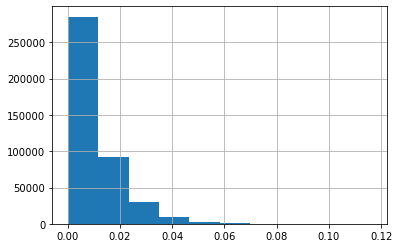

In [14]:
events["TD"][0:].hist()

### No integration

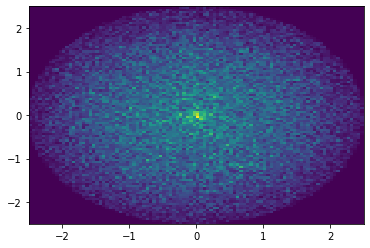

In [15]:
_ = plt.hist2d(x=events["DETX"], y=events["DETY"], bins=100)

<AxesSubplot:>

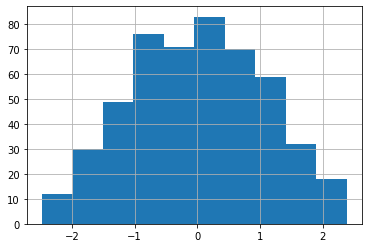

In [16]:
events["DETX"][0:500].hist()

<AxesSubplot:>

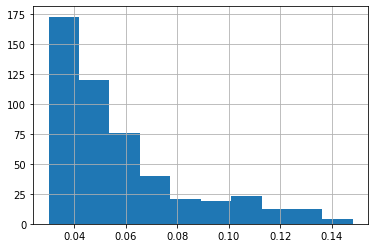

In [17]:
events["ENERGY"][0:500].hist()

In [18]:
events.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TIME,420610.0,2157.427934,1243.004209,0.001637,1081.466516,2156.788145,3229.625779,4311.873805
RA,420610.0,33.049988,1.743688,29.011778,31.737967,33.048470,34.360649,37.104603
DEC,420610.0,-51.830757,1.071412,-54.337841,-52.636833,-51.831451,-51.023758,-49.341675
ENERGY,420610.0,0.056758,0.025306,0.030000,0.038734,0.047820,0.066513,0.149990
DETX,420610.0,-0.002644,1.071571,-2.496886,-0.810347,-0.004458,0.803622,2.499305
DETY,420610.0,-0.004163,1.076991,-2.496602,-0.815921,-0.005300,0.806049,2.497838
TD,420610.0,0.010251,0.010226,0.000000,0.002961,0.007119,0.014218,0.116450


### Space/Time/Energy integration


In [19]:
from astro.lib.photometry import Photometrics
from RTAscience.lib.RTAUtils import get_pointing

In [20]:
events = pd.DataFrame()

#### Space

In [21]:
radius = 0.5

#### Time

In [22]:
t_bin_size = 10
t_shift = 10

#### Energy

In [23]:
energy_bins = []
print(f"Number of windows: {len(energy_bins)}. Examples: {energy_bins}")

Number of windows: 0. Examples: []


In [24]:
def get_bins(start, stop, binsize, shift):
    time_windows = []
    t_start = start
    t_stop = stop
    w_start = start
    while w_start + binsize < t_stop:
        time_windows.append( (round(w_start, 3), round(w_start + binsize, 3))  )
        w_start += shift
    return time_windows

In [25]:
time_bins = get_bins(0, cfg.get('tobs'), t_bin_size, t_shift)
print(f"Number of windows: {len(time_bins)} Example: {time_bins[0:5]}")

Number of windows: 359 Example: [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50)]


In [26]:
phm = Photometrics({ 'events_filename': inputFitsFile })
region = {
    'ra': get_pointing(datapath.joinpath(f'templates/{runid}.fits'))[0],
    'dec': get_pointing(datapath.joinpath(f'templates/{runid}.fits'))[1],
}

for energy_bin in energy_bins:
    region_counts = []
    for time_bin in time_bins:
        region_counts.append(phm.region_counter(region, radius, tmin=time_bin[0], tmax=time_bin[1], emin=energy_bin[0], emax=energy_bin[1]))
        #print(f"{time_bin} - {energy_bin}: {region_counts[-1]}")
    #events[energy_bins] = region_counts
    print(region_counts)


In [27]:
events.head()

""
